# Machine Learning (revenue_prediction)

In [2]:
# Packages / libraries
import os
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, explained_variance_score, mean_absolute_error, mean_squared_error
from math import sqrt
import json
import datetime as dt

In [3]:
# To change scientific numbers to float
np.set_printoptions(formatter={'float_kind':'{:f}'.format})

# Increases the size of sns plots
sns.set(rc={'figure.figsize':(5,5)})

# view all the dataframe
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)

# remove warnings
import warnings
warnings.filterwarnings("ignore")

## Loading the Raw Data

In [4]:
# Loading the data

with open(r"C:\Users\user\Downloads\accounton_data.json\accounton_data.json",'r') as f:
    raw_data = json.loads(f.read())

In [5]:
# Flatten data
data = pd.json_normalize(raw_data)


In [6]:
print(data.dtypes)

company_name         object
nace_code            object
vat_number           object
zipcode               int64
city                 object
                     ...   
staff_costs.2019    float64
staff_costs.2018    float64
staff_costs.2016    float64
staff_costs.2017    float64
staff_costs.2015    float64
Length: 75, dtype: object


# Data Preprocessing

In [7]:
# convert the CreationDate column into DateTime type Delet the companies the created after 2019 because it had many NaN values
data['creation_date'] = pd.to_datetime(data['creation_date']).dt.to_period('Y')

## Checking for the duplicated values

In [8]:
# checking the duplicated company
bool_series = data.duplicated()
bool_series

0        False
1        False
2        False
3        False
4        False
         ...  
49999    False
50000    False
50001    False
50002    False
50003    False
Length: 50004, dtype: bool

##  Checking for NULL Values

In [9]:
# Checking for null values
data.isnull().sum()

company_name            0
nace_code               0
vat_number              0
zipcode                 0
city                    0
                    ...  
staff_costs.2019    31132
staff_costs.2018    31569
staff_costs.2016    32485
staff_costs.2017    33830
staff_costs.2015    23800
Length: 75, dtype: int64

In [10]:
# Save the rows tha have values .. deleting the rows that have all NAN values
df1 = data[data['ebit.2019'].notna()]

In [11]:
# splitting the data frame based on 'company_category'
df_Large = df1.loc[df1['company_category']== "Large",:]
df_Medium = df1.loc[df1['company_category']== 'Medium sized',:]
df_Small = df1.loc[df1['company_category']== 'Small',:]
df_Very_large= df1.loc[df1['company_category']== 'Very large',:]

In [12]:
# fill the NAN values in each feature based on the mean values of the same category
years = ['2015', '2016','2017','2018','2019','2020']
Features = ['ebit', 'ebitda' , 'profit_and_loss_after_taxes' , 'total_assets' , 'total_liabilities' , 'operating_profit_and_loss' , 'financial_profit_and_loss' , 'staff_count', 'revenue' , 'net_added_value' , 'staff_costs']
for feature in Features:
    for year in years:
        df_Large[f'{feature}.{year}'][df_Large[f'{feature}.{year}'].isna()] = df_Large[f'{feature}.{year}'].mean()
        df_Medium[f'{feature}.{year}'][df_Medium[f'{feature}.{year}'].isna()] = df_Medium[f'{feature}.{year}'].mean()
        df_Small[f'{feature}.{year}'][df_Small[f'{feature}.{year}'].isna()] = df_Small[f'{feature}.{year}'].mean()
        df_Very_large[f'{feature}.{year}'][df_Very_large[f'{feature}.{year}'].isna()] = df_Very_large[f'{feature}.{year}'].mean()

In [13]:
# concatenate the subsets to get the clean dataframe
Total_clean_df = pd.DataFrame()
all_df1 = [df_Large,df_Medium,df_Small, df_Very_large ]
for each_df in all_df1:
    Total_clean_df = pd.concat([Total_clean_df,each_df])
Total_clean_df.shape

(38322, 75)

In [14]:
Total_clean_df.isna().sum()

company_name        0
nace_code           0
vat_number          0
zipcode             0
city                0
                   ..
staff_costs.2019    0
staff_costs.2018    0
staff_costs.2016    0
staff_costs.2017    0
staff_costs.2015    0
Length: 75, dtype: int64

# Reshape the data frame
### inorder to creat a new dataframe that appear the companies data based on year

In [15]:
reshape_df = pd.DataFrame()
full_df = pd.DataFrame()
years = ['2015', '2016','2017', '2018','2019']
Features = ['ebit', 'ebitda' , 'profit_and_loss_after_taxes' , 'total_assets' , 'total_liabilities' , 'operating_profit_and_loss' , 'financial_profit_and_loss' , 'staff_count' , 'net_added_value' , 'staff_costs']

for y in years:

                reshape_df['company_name'] = Total_clean_df['company_name']
                reshape_df['company_category'] = Total_clean_df['company_category']
                reshape_df['province'] = Total_clean_df['province']
                reshape_df['Year_of_P'] = y
                for f in Features:
                    reshape_df[f"{f}"] = Total_clean_df[f"{f}.{y}"]
                reshape_df[f"revenue"] = Total_clean_df[f"revenue.{str(int(y)+1)}"]
                
                full_df = pd.concat([full_df,reshape_df], axis=0)

full_df = full_df.sort_values(by=['company_name','Year_of_P'])
full_df

,company_name,company_category,province,Year_of_P,ebit,ebitda,profit_and_loss_after_taxes,total_assets,total_liabilities,operating_profit_and_loss,financial_profit_and_loss,staff_count,net_added_value,staff_costs,revenue
7404,#RTFW,Small,Limburg,2015,25547.754355,44677.521763,15054.353908,349915.669701,349899.725352,25548.941187,-2822.199587,2.996941,81275.050440,31125.695875,293393.472754
7404,#RTFW,Small,Limburg,2016,25891.556466,45433.443489,15754.907404,365860.233446,365827.259537,25892.728454,-2488.603024,12.981550,82739.640143,53001.995394,307278.386130
7404,#RTFW,Small,Limburg,2017,25400.202360,44578.907248,14946.958128,358836.907131,358822.051971,25401.272789,-2219.911341,3.072912,80635.975008,62784.825279,263036.495722
7404,#RTFW,Small,Limburg,2018,-10210.000000,-9975.000000,-10734.000000,48610.000000,48610.000000,-10210.000000,-525.000000,3.049934,-4752.000000,66823.477347,243388.674330
7404,#RTFW,Small,Limburg,2019,4393.000000,9284.000000,3528.000000,66066.000000,66066.000000,4393.000000,-1020.000000,3.107081,11924.000000,70569.577119,210704.559804
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30403,³FALCON & FRENS²,Small,Antwerp,2015,25547.754355,44677.521763,15054.353908,36537.000000,36537.000000,25548.941187,-2822.199587,2.996941,81275.050440,0.000000,293393.472754
30403,³FALCON & FRENS²,Small,Antwerp,2016,-13822.000000,-13822.000000,-13822.000000,627020.000000,627020.000000,-13822.000000,-2488.603024,12.981550,-13822.000000,53001.995394,307278.386130
30403,³FALCON & FRENS²,Small,Antwerp,2017,15619.000000,15619.000000,15600.000000,633832.000000,633832.000000,15619.000000,-19.000000,3.072912,15677.000000,62784.825279,263036.495722
30403,³FALCON & FRENS²,Small,Antwerp,2018,-1292.000000,-1292.000000,-1451.000000,634833.000000,634833.000000,-1292.000000,-158.000000,3.049934,-250.000000,0.000000,243388.674330


## Selecting the important features

### Heatmap

- First we need to create a "Dataset" to display on a Heatmap - we will use a correlation matrix
- .corr() is used to find the pairwise correlation of all columns in the dataframe. Any null values are automatically excluded

In [16]:
#selecting the columns that I want to check the correlation between them
n_variables = []
for f in Features:
    
        n_variables.append(f)
n_variables.append('revenue')

In [17]:
test_heat_df = full_df.loc[100]
test_heat_df

,company_name,company_category,province,Year_of_P,ebit,ebitda,profit_and_loss_after_taxes,total_assets,total_liabilities,operating_profit_and_loss,financial_profit_and_loss,staff_count,net_added_value,staff_costs,revenue
100,CATERPILLAR DISTRIBUTION SERVICES EUROPE,Very large,Vlaams Brabant,2015,2126449.0,8141027.0,2862703.0,86342884.0,86342884.0,2126449.0,2601709.0,704.0,59502677.0,47579766.0,99166240.0
100,CATERPILLAR DISTRIBUTION SERVICES EUROPE,Very large,Vlaams Brabant,2016,3246424.0,9726505.0,2755588.0,85661959.0,85661959.0,3246424.0,1435324.0,689.0,59729423.0,47081833.0,121738398.0
100,CATERPILLAR DISTRIBUTION SERVICES EUROPE,Very large,Vlaams Brabant,2017,9935482.0,15951421.0,3252155.0,90211092.0,90211092.0,9935482.0,-4278092.0,735.0,73636891.0,54388160.0,125755296.0
100,CATERPILLAR DISTRIBUTION SERVICES EUROPE,Very large,Vlaams Brabant,2018,4737000.0,10992504.0,3695667.0,96879096.0,96879096.0,4737000.0,1292848.0,769.0,69522286.0,57017584.0,145019281.0
100,CATERPILLAR DISTRIBUTION SERVICES EUROPE,Very large,Vlaams Brabant,2019,8352799.0,14836189.0,4312734.0,95964442.0,95964442.0,8352799.0,-1512019.0,798.0,79082881.0,58798186.0,131122698.0


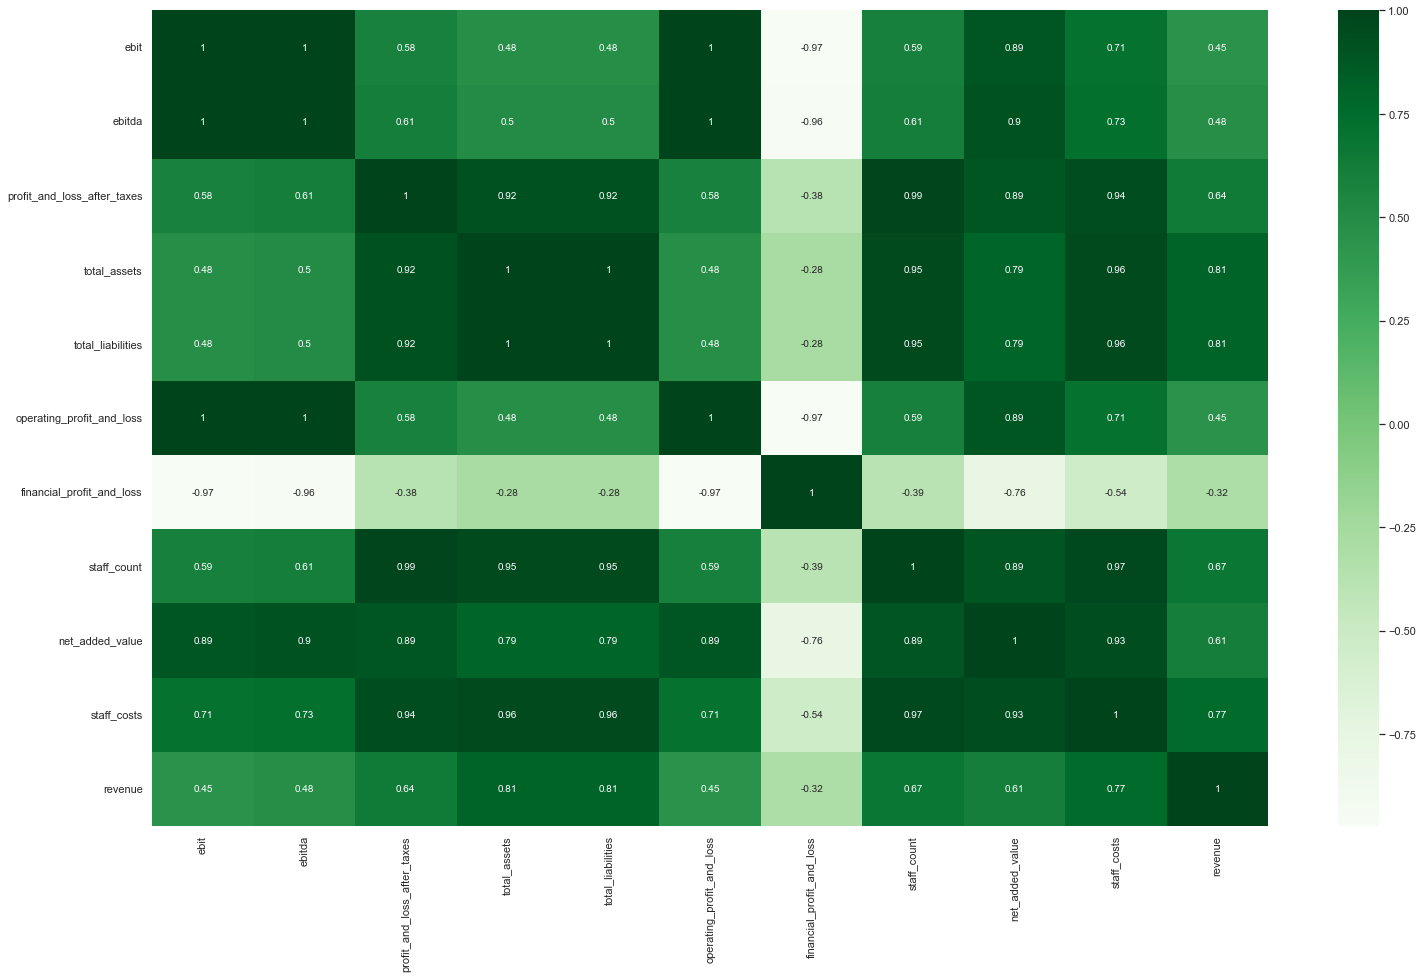

In [22]:
#  Heatmap for one company 
# Increases the size of sns plots
sns.set(rc={'figure.figsize':(25,15)})

# creating the correlation dataset using Pearson method (linear relation)
pc = test_heat_df[n_variables].corr(method ='pearson')

cols = n_variables
ax = sns.heatmap(pc, annot=True,
                 yticklabels=cols,
                 xticklabels=cols,
                 annot_kws={'size':10},
                 cmap="Greens")

## Repeating the steps for subset (2019,2020)

In [ ]:
# creating the dataframe for the last two years
df_two_years = pd.DataFrame()
rest_f = ['company_name', 'nace_code', 'vat_number', 'zipcode', 'city',
       'creation_date', 'legal_form', 'company_category', 'province',]
for i in rest_f:
     df_two_years[i]=Total_clean_df[i]

years = ['2019','2020']
Features = ['ebit', 'ebitda' , 'profit_and_loss_after_taxes' , 'total_assets' , 'total_liabilities' , 'operating_profit_and_loss' , 'financial_profit_and_loss' , 'staff_count', 'revenue' , 'net_added_value' , 'staff_costs']
for feature in Features:
    for year in years:
        df_two_years[f'{feature}.{year}'] = Total_clean_df[f'{feature}.{year}']


# df_two_years

In [ ]:
# Investigate all the elements whithin each Feature 

# for column in df_two_years:
#     unique_vals = np.unique(df_two_years[column])
#     nr_values = len(unique_vals)
#     if nr_values < 10:
#         print('The number of values for feature {} :{} -- {}'.format(column, nr_values,unique_vals))
#     else:
#         print('The number of values for feature {} :{}'.format(column, nr_values))

In [ ]:
# Check the NAN values in the subset of the two years 2019-2020
df_two_years.isna().sum()

company_name                        0
nace_code                           0
vat_number                          0
zipcode                             0
city                                0
creation_date                       1
legal_form                          0
company_category                    0
province                            0
ebit.2019                           0
ebit.2020                           0
ebitda.2019                         0
ebitda.2020                         0
profit_and_loss_after_taxes.2019    0
profit_and_loss_after_taxes.2020    0
total_assets.2019                   0
total_assets.2020                   0
total_liabilities.2019              0
total_liabilities.2020              0
operating_profit_and_loss.2019      0
operating_profit_and_loss.2020      0
financial_profit_and_loss.2019      0
financial_profit_and_loss.2020      0
staff_count.2019                    0
staff_count.2020                    0
revenue.2019                        0
revenue.2020

In [ ]:
# Create a subset from df1 to check the method of cleaning data
new_two_years = df_two_years.iloc[0:10000,:]

In [ ]:
# splitting the data frame based on 'company_category'
df_NLarge = new_two_years.loc[new_two_years['company_category']== "Large",:]
df_NMedium = new_two_years.loc[new_two_years['company_category']== 'Medium sized',:]
df_NSmall = new_two_years.loc[new_two_years['company_category']== 'Small',:]
df_NVery_large= new_two_years.loc[new_two_years['company_category']== 'Very large',:]

In [ ]:
# concatenate the subsets to get the clean dataframe
New_clean_df = pd.DataFrame()
all_df = [df_NLarge,df_NMedium,df_NSmall, df_NVery_large ]
for d in all_df:
    New_clean_df = pd.concat([New_clean_df,d])
New_clean_df.shape

(10000, 31)

### Visualizing The data

In [ ]:
#  Visualize the data using seaborn Pairplots
years = ['2019','2020']
Features = [ 'total_assets' , 'total_liabilities' , 'operating_profit_and_loss' , 'financial_profit_and_loss' , 'revenue']
f_list = []
for feature in Features:
    for year in years:
        f_list.append(f'{feature}.{year}')
f_list.append('company_category')

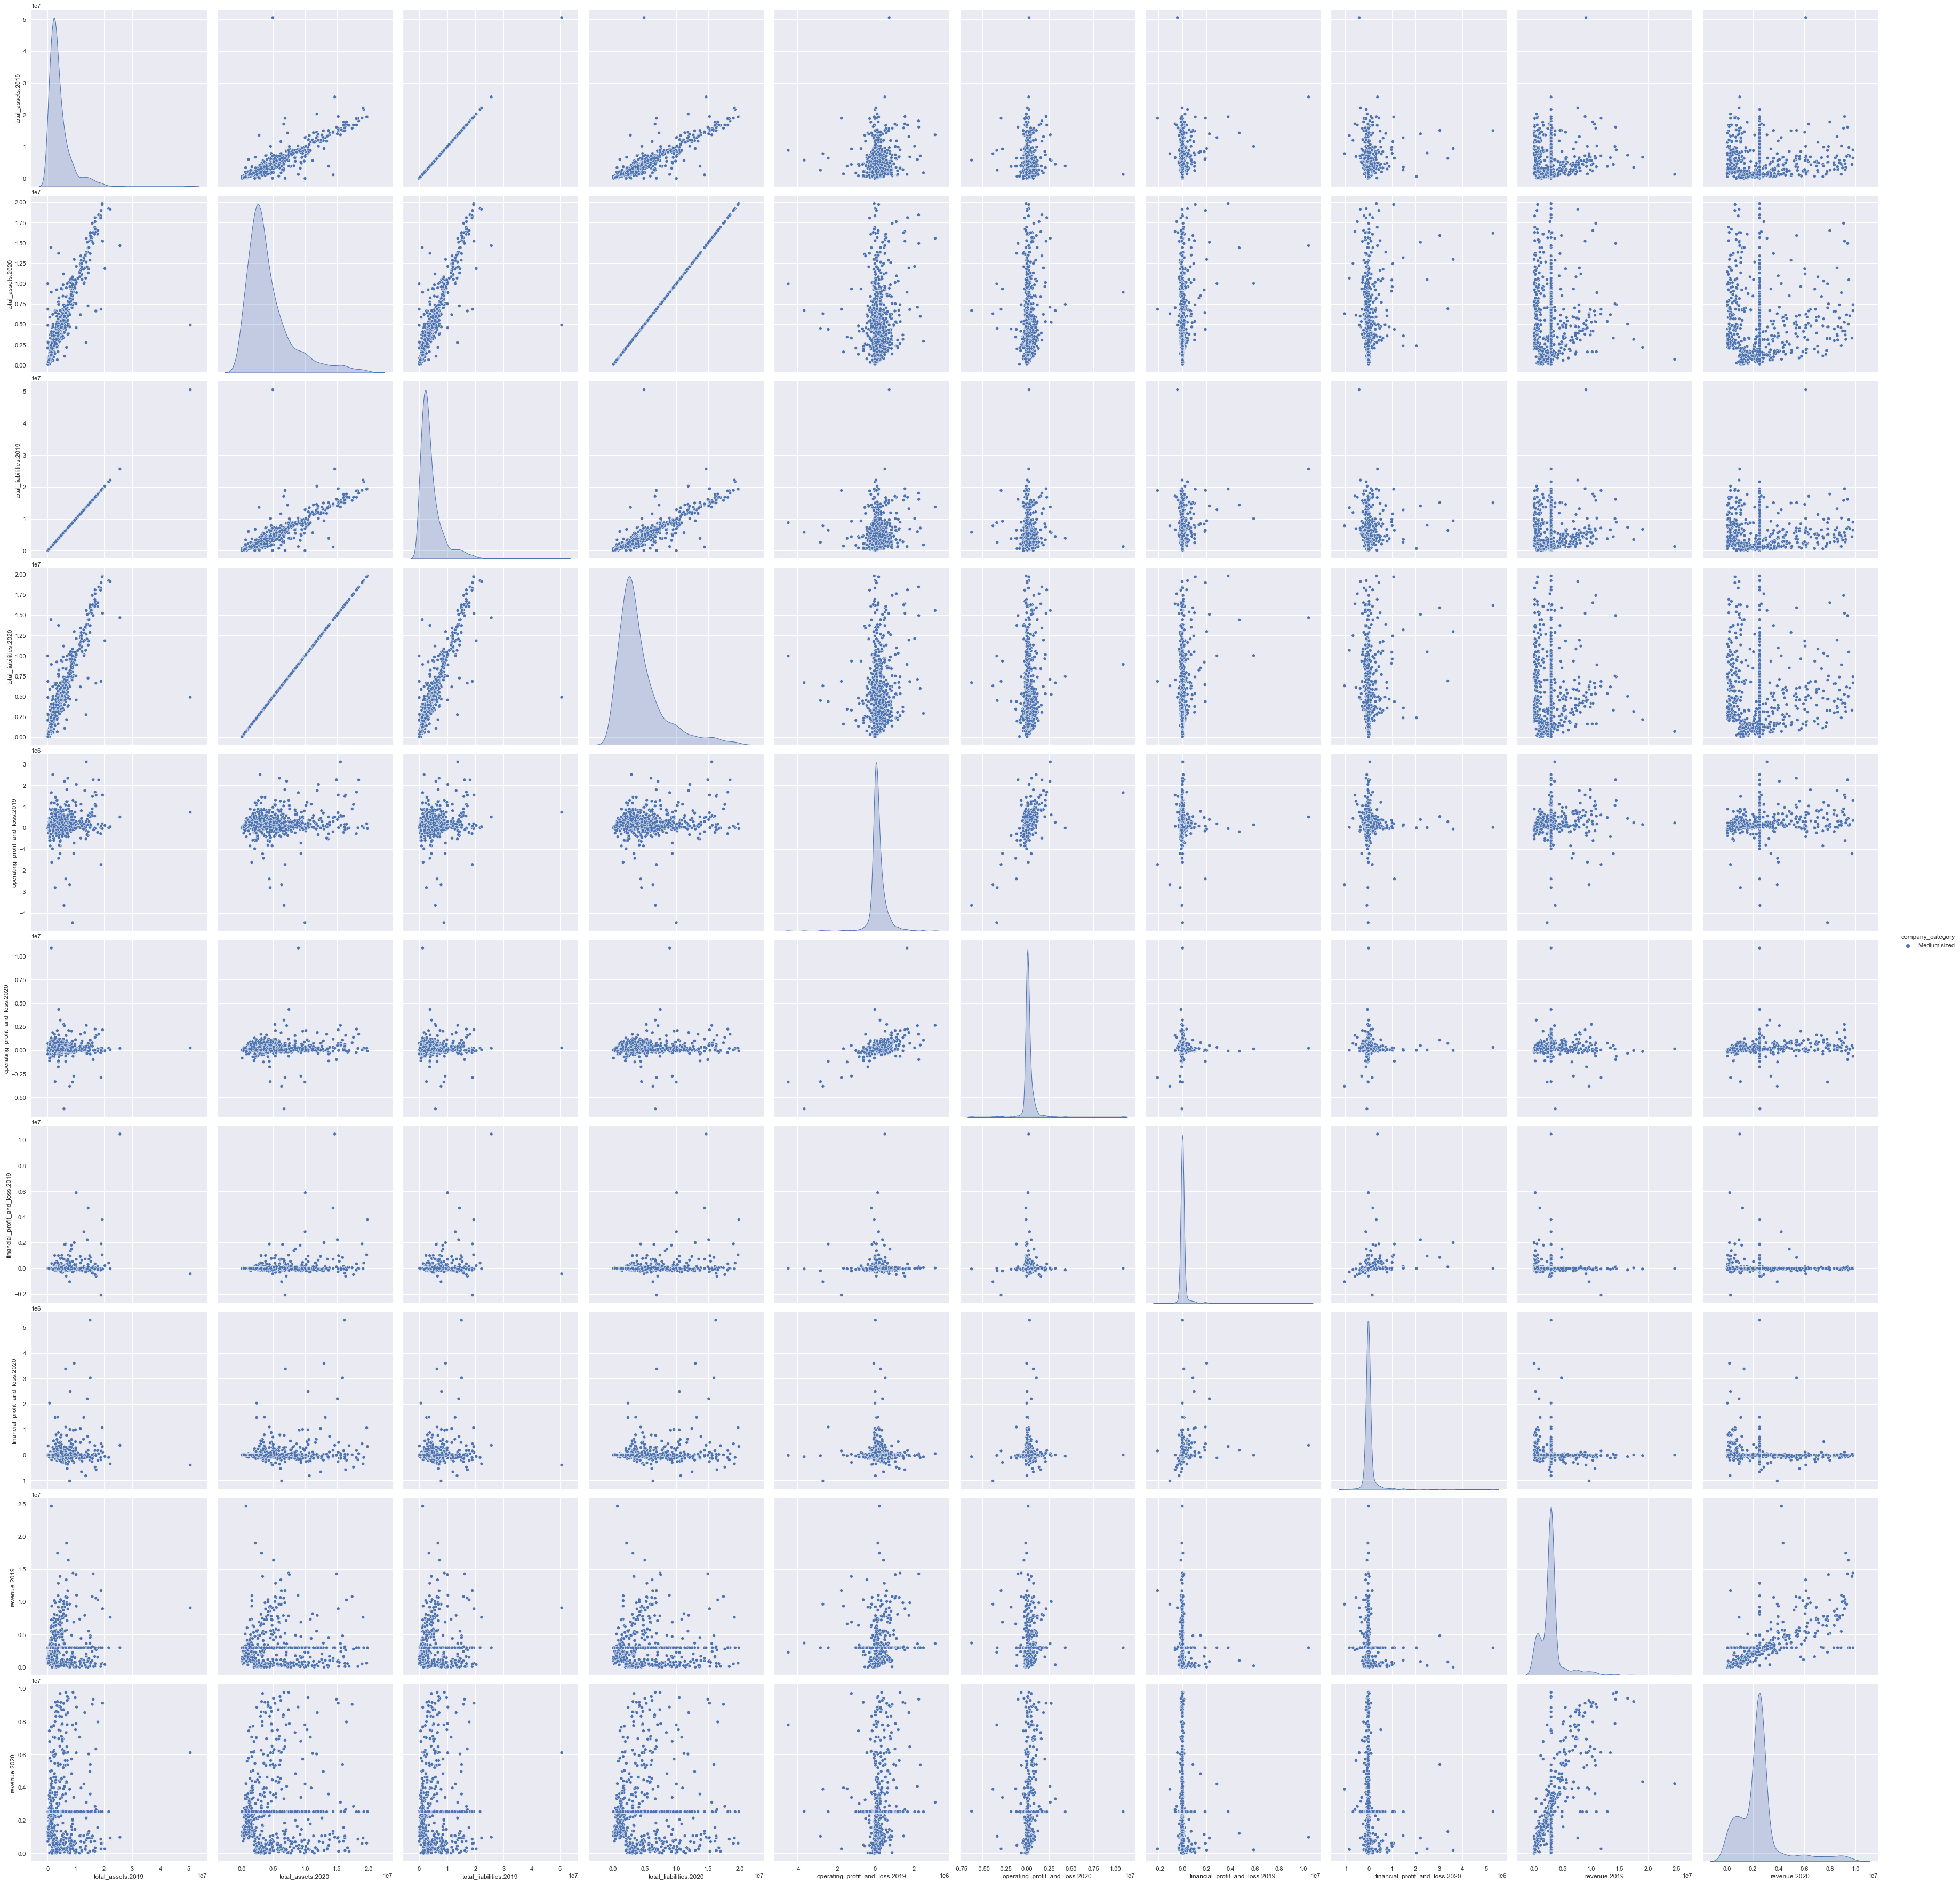

In [ ]:

g = sns.pairplot(df_NMedium[f_list], hue= 'company_category', height = 5)


### Find the correlation between the features

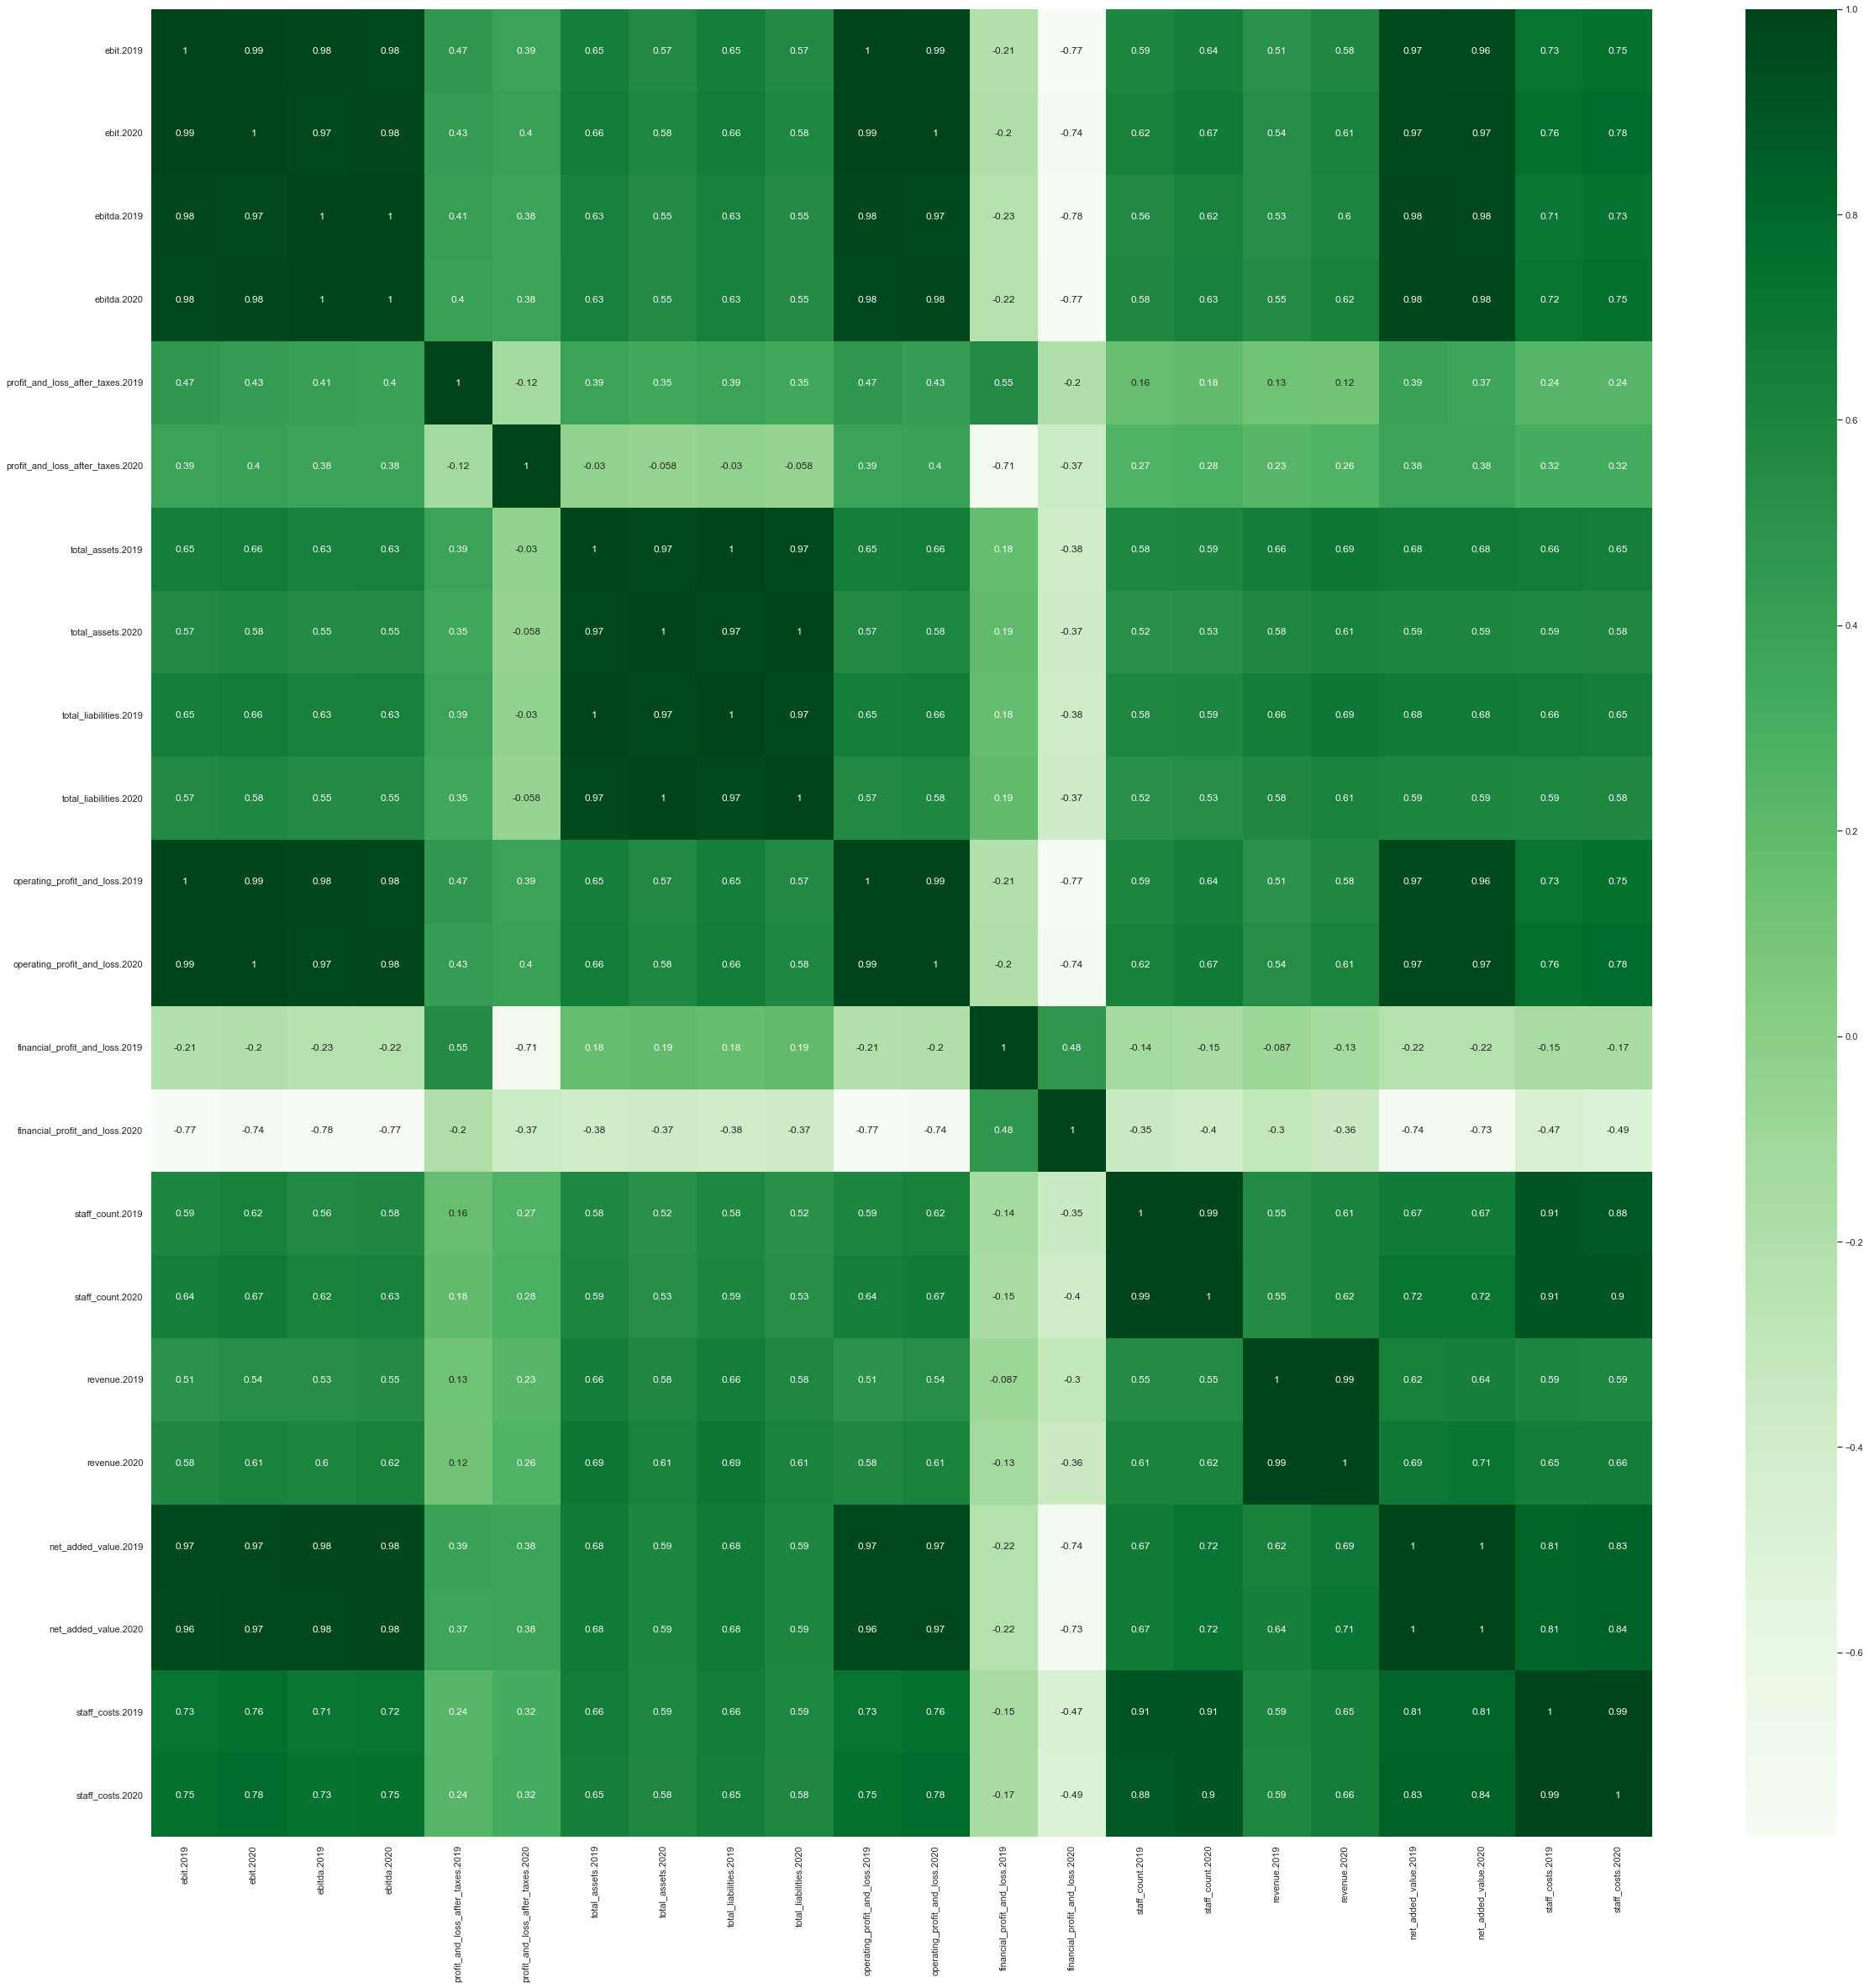

In [ ]:
#  Heatmap for the years (2020, 2019)
# Increases the size of sns plots
sns.set(rc={'figure.figsize':(40,40)})

#selecting the columns that I want to check the correlation between them
n_variables = [
       'ebit.2019', 'ebit.2020', 'ebitda.2019', 'ebitda.2020',
       'profit_and_loss_after_taxes.2019', 'profit_and_loss_after_taxes.2020',
       'total_assets.2019', 'total_assets.2020', 'total_liabilities.2019',
       'total_liabilities.2020', 'operating_profit_and_loss.2019',
       'operating_profit_and_loss.2020', 'financial_profit_and_loss.2019',
       'financial_profit_and_loss.2020', 'staff_count.2019',
       'staff_count.2020', 'revenue.2019', 'revenue.2020',
       'net_added_value.2019', 'net_added_value.2020', 'staff_costs.2019',
       'staff_costs.2020']

# creating the correlation dataset using Pearson method (linear relation)
pc = New_clean_df[n_variables].corr(method ='pearson')

cols = n_variables
ax = sns.heatmap(pc, annot=True,
                 yticklabels=cols,
                 xticklabels=cols,
                 annot_kws={'size':12},
                 cmap="Greens")